In [1]:
% matplotlib inline
import timeit
import math

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString

base1 = Polygon([
    (-32.1665052195, 244.951010361),
    (0.0, 0.0),
    (164.100332863, -6.72252704724),
    (258.444740993, 131.833417876),
    (81.6832775051, 124.859373939),
    (75.3190068965, 248.195464884),
    (-32.1665052195, 244.951010361),
])

base2 = Polygon([
    (-49.4396391714, 329.180218029),
    (-92.9129195885, 247.064021685),
    (-57.9893698290, 147.064434513),
    (10.0375541578, 123.960950894),
    (42.1257258497, 41.8152313633),
    (0.0, 0.0),
    (243.639444075, -12.0928970791),
    (165.344305147, 76.4704567905),
    (128.122025984, 171.451444998),
    (75.3190068965, 248.195464884),
    (11.3210810255, 302.371185501),
    (-16.9165100634, 338.309937796),
    (-49.4396391714, 329.180218029)
])

base3 = Polygon([
    (-1.51418765128, -3.10820900539),
    (264.175873958, -3.10820900539),
    (264.175873958, 263.865379471),
    (-1.51418765128, 263.865379471),
    (-1.51418765128, -3.10820900539)
])

base4 = Polygon([
    (7.47050042245, 4.59295220067),
    (65.2292094678, 301.087658634),
    (135.823187190, 337.026410929),
    (289.846411311, 369.114582620),
    (465.689592183, 347.294625870),
    (595.325805818, 225.359573441),
    (603.026967024, 88.0221985996),
    (440.019054829, -6.95878960841),
    (300.114626252, -74.9857135952),
    (7.47050042245, 4.59295220067),
])

base5 = Polygon([
    (9.73997200653, -0.429771980603),
    (32.7216291224, 291.150002677),
    (126.084611155, 396.003813268),
    (252.483725293, 434.785359651),
    (263.974553851, 351.476852606),
    (355.901182314, 253.804809863),
    (582.845046333, 207.841495632),
    (627.372006995, 46.9698958208),
    (465.064053614, 6.75199586810),
    (222.320300328, 146.078292133),
    (118.902843307, 35.4790672629),
    (9.73997200653, -0.429771980603)
])
series = [base1, base2, base3, base4, base5]

41087.077480508946


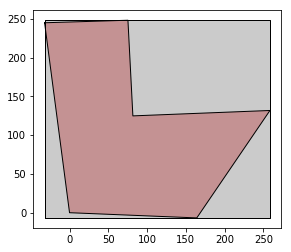

In [245]:
base = base1
print(base.area)
gpd.GeoSeries([base,base.envelope]).plot()

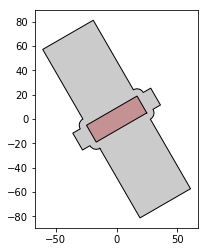

In [327]:
from shapely.ops import cascaded_union


def get_corners(length, width, rotate_angle, center):
    if isinstance(center, Point):
        x = center.coords[0][0]
        y = center.coords[0][1]
    else:
        x = center[0]
        y = center[1]
    diagonal = math.sqrt(length ** 2 + width ** 2)
    r = diagonal / 2
    rotate_angle = math.radians(rotate_angle)
    original_angle = math.atan2(width, length)
    pointA_angle = -original_angle + rotate_angle
    pointB_angle = +original_angle + rotate_angle
    pointC_angle = math.pi - original_angle + rotate_angle
    pointD_angle = math.pi + original_angle + rotate_angle
    corners = [(r * math.cos(pointA_angle) + x, r * math.sin(pointA_angle) + y),
               (r * math.cos(pointB_angle) + x, r * math.sin(pointB_angle) + y),
               (r * math.cos(pointC_angle) + x, r * math.sin(pointC_angle) + y),
               (r * math.cos(pointD_angle) + x, r * math.sin(pointD_angle) + y)]
    return corners


def get_building(length, width, rotate_angle, center=(0, 0)):
    corners = get_corners(length, width, rotate_angle, center)
    return Polygon(corners)


def get_building_shadow(length, width, rotation_angle, center=(0, 0), h=80):
    shadow_list = []
    shadow_long = get_building(length=length + 26, width=width, rotate_angle=rotation_angle, center=center)
    shadow_height = get_building(length=length, width=2 * h, rotate_angle=rotation_angle, center=center)
    shadow_list.append(shadow_long)
    shadow_list.append(shadow_height)
    corners = get_corners(length, width, rotation_angle, center)
    for corner in corners:
        shadow_list.append(Point(corner).buffer(6, 4))
    shadow = cascaded_union(shadow_list)
    return shadow

polygon2 = get_building(48, 16, 30, (0, 0))
polygon4 = get_building_shadow(48, 16, 30, (0, 0))
gdf = gpd.GeoSeries([polygon2, polygon4])
gdf.plot()

0.8719863133241262


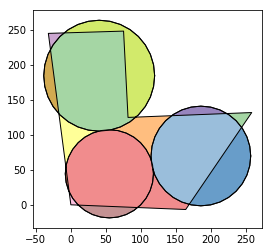

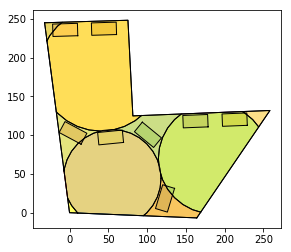

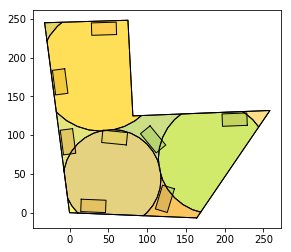

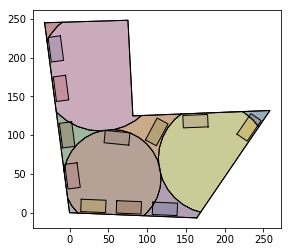

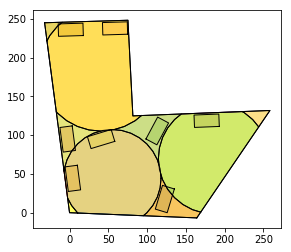

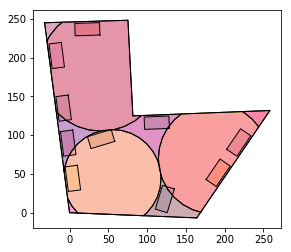

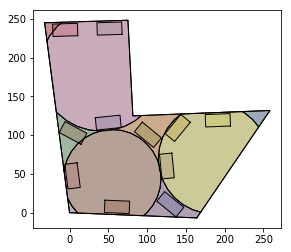

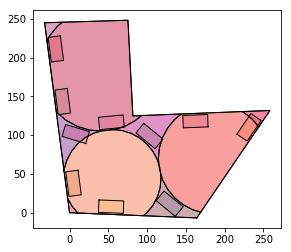

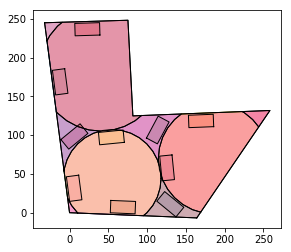

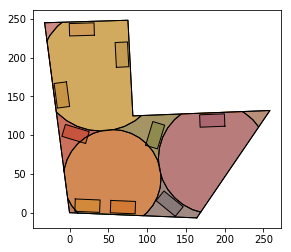

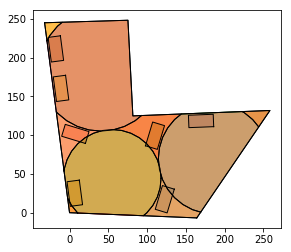

In [334]:
# gpd.GeoSeries(point_list).plot()

import random

from shapely.geometry import *


def generate_collection(min_r, max_r, resolution=4):
    envelope = base.envelope
    minx, miny, maxx, maxy = envelope.bounds
    number = 20
    x_diff = maxx - minx
    y_diff = maxy - miny
    point_list = []
    for j in range(number):
        for i in range(number):
            point = Point(minx + x_diff / number * i, miny + y_diff / number * j)
            if base.buffer(-10).contains(point):
                point_list.append(point)
                
    collection = []
    max_iteration = 1000
    iter = 0
    while len(point_list) > 0 or iter > max_iteration:
        iter += 1
        first_point = random.choice(point_list)
        if len(collection) == 0:
            r = random.randint(min_r, max_r)
            circle = first_point.buffer(r, resolution)
            collection.append(circle)
            point_list.remove(first_point)
        else:
            distances = [first_point.distance(circle) for circle in collection]
            min_distance = min(distances)
            if min_distance < min_r:
                point_list.remove(first_point)
            elif min_distance > max_r:
                continue
            else:
                circle = first_point.buffer(min_distance+1, resolution)
                collection.append(circle)
                point_list.remove(first_point)
    return collection


max_coverage = 0
current_collection = []
for i in range(1):
    # print(i)
    collection = generate_collection(60, 80, resolution=8)
    coverage = sum([geom.intersection(base).area for geom in collection]) / base.area
    # print(coverage, max_coverage)
    if coverage > max_coverage:
        max_coverage = coverage
        current_collection = collection
from shapely.ops import cascaded_union
the_union = cascaded_union(current_collection)
other_part = base.symmetric_difference(the_union)
# current_collection.append(other_part)
for part in other_part:
    current_collection.append(part)

print(max_coverage)
# current_collection.append(base)
gpd.GeoSeries(current_collection).plot()
new_collection = [geom.intersection(base) for geom in current_collection]
new_collection = sorted(new_collection, key=lambda geom:geom.area)

for i in range(10):
    overall_buildings = None
    list_to_display = []
    overall_shadows = base.symmetric_difference(base.envelope)
    for our_base in new_collection:
        import random
        building_line = our_base.buffer(-10)
        if building_line.is_empty:
            continue
        building_line = building_line.boundary
        try:
            building_coords = building_line.coords
        except:
            continue
        building_point_list = []
        k = random.choice(range(len(building_coords)))
    
        for i in range(k, k + len(building_coords) - 1):
            start_point = building_coords[i % len(building_coords)]
            end_point = building_coords[(i + 1) % len(building_coords)]
            startx = start_point[0]
            starty = start_point[1]
            endx = end_point[0]
            endy = end_point[1]
            line = LineString([start_point, end_point])
            if line.length < 1:
                continue
            else:
                angle = math.degrees(math.atan2(endy - starty, endx - startx))
                for j in range(10):
                    k = random.randint(0, 9)
                    center = (startx + ((j + k) % 10) * (endx - startx) / 10, starty + ((j + k) % 10) * (endy - starty) / 10)
                    building = get_building(32, 16, angle, center=center)
                    shadow = get_building_shadow(32, 16, angle, center=center)
                    if not overall_buildings:
                        if overall_shadows.intersects(building):
                            continue
                        else:
                            overall_buildings = building
                    elif overall_shadows.intersects(building) or overall_buildings.intersects(shadow):
                        continue
                    else:
                        overall_shadows = overall_shadows.union(shadow)
                        overall_buildings = overall_buildings.union(building)
    # list_to_display.extend(overall_shadows)
    list_to_display.extend(overall_buildings)
    list_to_display.extend(new_collection)
    list_to_display.append(base)
    gpd.GeoSeries(list_to_display).plot()

LINESTRING (483.9156737036901 147.0644345124001, 305.2487337232252 169.2694493231601)
LINESTRING (305.2487337232252 169.2694493231601, 215.9152637329925 36.03936045859999)
LINESTRING (305.2487337232252 169.2694493231601, 186.137440402915 280.2945233769601)
LINESTRING (305.2487337232252 169.2694493231601, 394.5822037134573 324.7045529984801)
LINESTRING (215.9152637329925 36.03936045859999, 67.02614708260499 124.85941970164)
LINESTRING (215.9152637329925 36.03936045859999, 364.8043803833802 13.83434564784001)


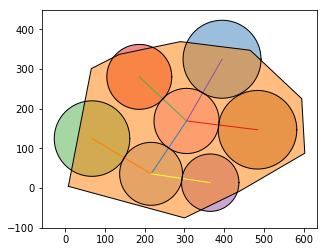

In [4]:
from shapely import affinity
roads = []
for i in range(len(current_collection)-1):
    for j in range(i+1, len(current_collection)):
        element1 = current_collection[i]
        element2 = current_collection[j]
        if element1.intersects(element2):
            roads.append(LineString([element1.centroid, element2.centroid]))
            print(LineString([element1.centroid, element2.centroid]))
roads.extend(current_collection)
roads.append(base)
gpd.GeoSeries(roads).plot()

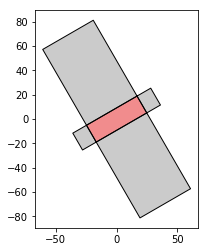

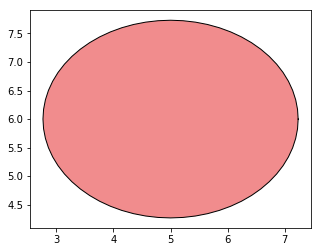

In [5]:
from mytry import get_eclipse
eclipse = get_eclipse(5, 3, (5, 6))
gpd.GeoSeries([eclipse]).plot()

(2.241150126735, -22.49571407856, 180.9080901072, 110.734374786) 17682.349051814203 (2.241150126735, -22.49571407856, 180.9080901072, 110.734374786)


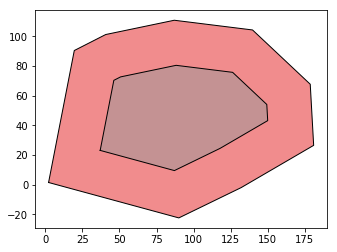

In [11]:
from shapely.affinity import *
our_base = scale(base4, xfact=0.3, yfact=0.3, origin=(0, 0))
print(our_base.bounds, our_base.area, our_base.envelope.bounds)
gpd.GeoSeries([our_base, our_base.buffer(-30)]).plot()

In [ ]:
import random
building_line = our_base.buffer(-30).boundary
building_vertical_line = our_base.buffer(-30).boundary
building_coords = building_line.coords
building_point_list = []
k = random.choice(range(len(building_coords)))

shadows = None
buildings = None
for i in range(k, k + len(building_coords) - 1):
    start_point = building_coords[i % len(building_coords)]
    end_point = building_coords[(i + 1) % len(building_coords)]
    startx = start_point[0]
    starty = start_point[1]
    endx = end_point[0]
    endy = end_point[1]
    line = LineString([start_point, end_point])
    if line.length < 0:
        continue
    else:
        angle = math.degrees(math.atan2(endy - starty, endx - startx))
        for j in range(10):
            k = random.randint(0, 9)
            center = (startx + ((j + k) % 10) * (endx - startx) / 10, starty + ((j + k) % 10) * (endy - starty) / 10)
            building = get_building(32, 16, angle, center=center)
            shadow = get_building_shadow(32, 16, angle, center=center)
            if not shadows:
                shadows = shadow
                buildings = building
            elif shadows.intersects(building) or buildings.intersects(shadow):
                continue
            else:
                shadows = shadows.union(shadow)
                buildings = buildings.union(building)

gpd.GeoSeries([building_line, buildings, our_base]).plot()

11.768288931708696


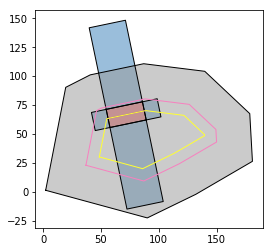

In [44]:
center = line.centroid
coords = line.coords
point_start = coords[0]
point_end = coords[1]
angle = math.degrees(math.atan2(point_end[1]-point_start[1], point_end[0]-point_start[0]))
print(angle)
building = get_building(32, 16, angle, center=center)
shadow = get_building_shadow(32, 16, angle, center=center)
gpd.GeoSeries([building, shadow, line, building_line, building_vertical_line, our_base]).plot()